## Step 1: Load& Prepare the data

#### 1.1 Install Required Dependencies

In [ ]:
import pandas as pd
import numpy as np

## import Torch Modules
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

In [ ]:
!pip install transformers

In [ ]:
# check device type: gpu or cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if __name__=='__main__':
    print('Using device:', device)

Using device: cuda


In [ ]:
# mount to google drive folder
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### 1.2 Load Data

In [ ]:
# read train and test dataset from previous step

X_train = pd.read_csv("/content/drive/My Drive/CS410Project/data/X_train.csv")
y_train = pd.read_csv("/content/drive/My Drive/CS410Project/data/y_train.csv")

X_test = pd.read_csv("/content/drive/My Drive/CS410Project/data/X_test.csv")
y_test = pd.read_csv("/content/drive/My Drive/CS410Project/data/y_test.csv")

In [ ]:
# validate shape
assert(X_train.shape[0] == y_train.shape[0])
assert(X_test.shape[0] == y_test.shape[0])
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((35163, 4), (35163, 1), (8791, 4), (8791, 1))

In [ ]:
# check data content
X_train.head()

,title,text,subject,date
0,one person hillarys shortlist vp removed dnc s...,puzzles figuring stuff loving past weeks tryin...,News,"July 15, 2016"
1,final sunday night football game canceled low ...,nfl announced tuesday final sunday night footb...,politics,"Dec 26, 2017"
2,trump black republican removed campaign event,many black republican party officials united s...,News,"June 21, 2016"
3,boiler room swear jar overfloweth,tune alternate current radio network acr anoth...,US_News,"January 6, 2017"
4,california poised shut republicans yous senate...,sacramento calif reuters california voters tue...,politicsNews,"June 7, 2016"


In [ ]:
# merge new title and text content together for modeling
X_train['corpus'] = X_train['title'] + X_train['text']
X_test['corpus'] = X_test['title'] + X_test['text']

In [ ]:
# check merged content
X_train.head()

,title,text,subject,date,corpus
0,one person hillarys shortlist vp removed dnc s...,puzzles figuring stuff loving past weeks tryin...,News,"July 15, 2016",one person hillarys shortlist vp removed dnc s...
1,final sunday night football game canceled low ...,nfl announced tuesday final sunday night footb...,politics,"Dec 26, 2017",final sunday night football game canceled low ...
2,trump black republican removed campaign event,many black republican party officials united s...,News,"June 21, 2016",trump black republican removed campaign eventm...
3,boiler room swear jar overfloweth,tune alternate current radio network acr anoth...,US_News,"January 6, 2017",boiler room swear jar overflowethtune alternat...
4,california poised shut republicans yous senate...,sacramento calif reuters california voters tue...,politicsNews,"June 7, 2016",california poised shut republicans yous senate...


In [ ]:
# check null value
X_train.isnull().sum()

title      0
text       0
subject    0
date       0
corpus     0
dtype: int64

## Step 2: Build BERT Model 

#### 2.1 Load and Construct BERT Model from Transformers

In [ ]:
# BERT
from transformers import BertForSequenceClassification, BertTokenizer, AdamW

bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", # Use uncased the 12-layer BERT model
                                                                num_labels = 2, # it's a binary classification problem so we define num_label as 2
                                                                output_attentions = False, 
                                                                output_hidden_states = False 
                                                          )
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased") # use pretrained bert uncased tokenizer which will conduct embedding automatically
# Tell pytorch to run this model on the GPU.
bert_model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

#### 2.2 Data Loader

In [ ]:
# write a function to parse dataset into tensors
def load_data_to_tensor(X_df, y_df, batch_size):
    bert_input_ids = []
    bert_attention_masks = []
    count = 0
    for news in X_df.corpus:
        bert_encoded_dict = bert_tokenizer.encode_plus(
                            news,                      # news title and text to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 120,           # Pad & truncate all news.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attetion masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                      )
        bert_input_ids.append(bert_encoded_dict['input_ids'])
        bert_attention_masks.append(bert_encoded_dict['attention_mask'])
        count  = count + 1
    print(count)

    bert_input_ids = torch.cat(bert_input_ids, dim=0)
    bert_attention_masks = torch.cat(bert_attention_masks, dim=0)
    labels = torch.tensor(y_df.isReal.values)

    df_dataset = TensorDataset(bert_input_ids, bert_attention_masks, labels) # put input sentences embedding, attention mask and label together into tensor dataset for training
    df_dataloader = DataLoader(
                df_dataset,  
                sampler = RandomSampler(df_dataset), # shuffle the batch randomly
                batch_size = batch_size # define training batch size.
            )
    return df_dataset, df_dataloader

#### 2.3 Choose Optimizer & Learning Rate

In [ ]:
# define optimzer: we use adam optimizer here as it's the state of art optimizer in most classification problems.
bert_optimizer = AdamW(bert_model.parameters(),
                  lr = 5e-5, # learning_rate, this rate has been tuned
                  eps = 1e-8 # adam_epsilon
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

# load train and validation data using our function
train_dataset, train_dataloader = load_data_to_tensor(X_train[:10000], y_train[:10000], batch_size=64)
valid_dataset, valid_dataloader = load_data_to_tensor(X_test, y_test, batch_size=64)

# intialize the scheduler for training
epochs = 3
total_steps = len(train_dataset) * epochs
bert_scheduler = get_linear_schedule_with_warmup(bert_optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


10000
8791


#### 2.4 Train BERT on News Dataset

In [ ]:
import numpy as np
import time
import datetime

#HELP FUNCTIONS

# function to calculate the accuracy of our predictions vs labels
def calculate_accuracy(preds, labels):
    flatted_pred = np.argmax(preds, axis=1).flatten()
    flatted_labels = labels.flatten()
    return np.sum(flatted_pred == flatted_labels) / len(flatted_labels)

# function to format the time and track the time use for training model
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random

# set seed 
seed_val = 100

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# to store stats about training and valid results
training_stats = []

# loop through each epoch:
for epoch_i in range(0, epochs):
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # measure how long the training epoch takes:
    start_time = time.time()

    # reset the total loss for this epoch.
    total_train_loss = 0
    bert_model.train()

    # for each batch:
    for step, batch in enumerate(train_dataloader):

        # print progress every 100 batches.
        if step % 100 == 0 and not step == 0:
            # calculate elapsed time in minutes.
            elapsed = format_time(time.time() - start_time)
            # update progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.   Loss: {}'.format(step, len(train_dataloader), elapsed, total_train_loss))
        
        batch_input_ids = batch[0].to(device)
        batch_input_mask = batch[1].to(device)
        batch_labels = batch[2].to(device)
        # print(batch_input_ids.shape, batch_input_mask.shape, batch_labels.shape)
        bert_model.zero_grad()  
        output = bert_model(batch_input_ids, 
                          token_type_ids=None, 
                          attention_mask=batch_input_mask, 
                          labels=batch_labels)
        total_train_loss += output.loss.item()
        output.loss.backward()
        torch.nn.utils.clip_grad_norm_(bert_model.parameters(), 1.0)
        bert_optimizer.step()
        bert_scheduler.step()
        
    avg_train_loss = total_train_loss / len(train_dataloader) 
    training_time = format_time(time.time() - start_time)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After each training epoch, measure our performance on validation set.

    print("")
    print("Running Validation...")
    start_time = time.time()

    # switch bert model to eval mode
    bert_model.eval()

    # track stats
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # evaluate data for one epoch
    for batch in valid_dataloader:
        batch_input_ids = batch[0].to(device)
        batch_input_mask = batch[1].to(device)
        batch_labels = batch[2].to(device)
        with torch.no_grad():        
            output = bert_model(batch_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=batch_input_mask,
                                   labels=batch_labels)
        total_eval_loss += output.loss.item()
        logits = output.logits.detach().cpu().numpy()
        label_ids = batch_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += calculate_accuracy(logits, label_ids)

        # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(valid_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(valid_dataloader)
    
    # Measure how long the validation run took.
    valid_time = format_time(time.time() - start_time)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(valid_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': valid_time
        }
    )

print("")
print("Training complete!")



======== Epoch 1 / 3 ========
Training...
  Batch   100  of    157.    Elapsed: 0:03:47.   Loss: 11.088776766962837

  Average training loss: 0.08
  Training epcoh took: 0:05:55

Running Validation...
  Accuracy: 1.00
  Validation Loss: 0.02
  Validation took: 0:01:54

======== Epoch 2 / 3 ========
Training...
  Batch   100  of    157.    Elapsed: 0:03:47.   Loss: 1.1644650259113405

  Average training loss: 0.01
  Training epcoh took: 0:05:55

Running Validation...
  Accuracy: 1.00
  Validation Loss: 0.01
  Validation took: 0:01:54

======== Epoch 3 / 3 ========
Training...
  Batch   100  of    157.    Elapsed: 0:03:47.   Loss: 0.472014751896495

  Average training loss: 0.01
  Training epcoh took: 0:05:55

Running Validation...
  Accuracy: 1.00
  Validation Loss: 0.01
  Validation took: 0:01:54

Training complete!


#### Evaluation

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,7.88e-02,1.65e-02,1.0,0:05:55,0:01:54
2,9.82e-03,1.13e-02,1.0,0:05:55,0:01:54
3,5.84e-03,7.64e-03,1.0,0:05:55,0:01:54


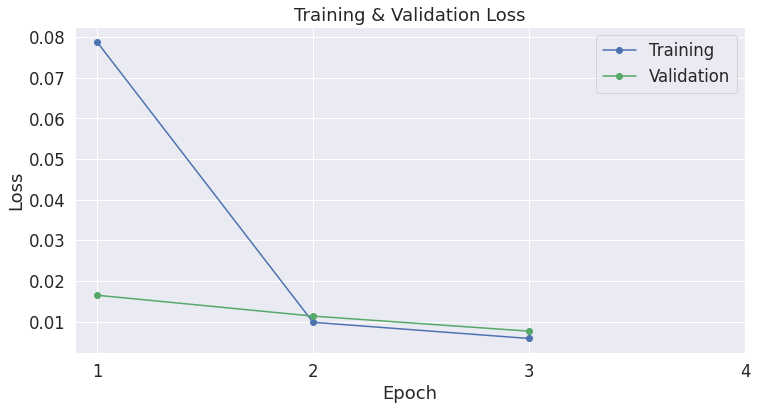

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

#### Save Model

In [ ]:
if __name__=='__main__':
    if bert_model is not None:
        print("Saving BERT model....") 
        torch.save(bert_model, '/content/drive/My Drive/CS410Project/BERT_300.pt')

Saving BERT model....
